# **AI BiasBuster: Detecting and Mitigating Bias in Text**
Welcome to the **AI BiasBuster** project! In this notebook, you will learn how to:
1. Detect biases in text using a fine-tuned transformer model.
2. Use the **WINOGENDER dataset** to train and evaluate your model.
3. Save and test your trained model for real-world use.

This notebook is beginner-friendly and assumes a basic understanding of Python and machine learning concepts. Let’s get started!

---

## **Introduction**
### **Why Detect Bias in AI?**
AI systems are increasingly used in sensitive applications like hiring, healthcare, and content moderation. However, these systems can inherit biases present in the data they’re trained on. This project aims to detect such biases and mitigate them to create more fair and ethical AI systems.

We’ll use the following tools:
- **Hugging Face Transformers**: For fine-tuning the DistilBERT model.
- **WINOGENDER Dataset**: A dataset designed to expose gender biases in language.
- **PyTorch**: To run and train our machine learning model.





## **Step 1: Install and Import Libraries**
Before we dive into the dataset or model, we need to ensure all the required libraries are installed.

### **What Are We Installing?**
- **Transformers**: For working with pre-trained models like DistilBERT.
- **Datasets**: To load and preprocess our dataset.
- **Torch**: For model training and inference.

Let’s install and import these libraries.

In [15]:
!pip install transformers datasets torch scikit-learn


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


In [16]:
# Import essential libraries
from datasets import load_dataset
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from collections import Counter
from datasets import DatasetDict
from transformers import TrainingArguments
from transformers import pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support






In [17]:
# Check if GPU is available (optional but recommended)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


## **Step 2: Load and Explore the Dataset**
### **Why the WINOGENDER Dataset?**
The WINOGENDER dataset is specifically designed to reveal gender biases in language. It contains sentences where the gender of entities can be inferred, often leading to biased associations (e.g., "nurse" is stereotypically associated with females).

### **What Will We Do in This Step?**
1. Load the WINOGENDER dataset.
2. Explore its structure and contents.
3. Understand how it’s used for training.

Let’s start by loading the dataset and inspecting its contents.


In [18]:
from datasets import DatasetDict

# Load the dataset
dataset = load_dataset("oskarvanderwal/winogender", "all")

# Check available splits
print("Available splits:", dataset.keys())

# Split the 'test' data into 'train' and 'validation'
data_split = dataset["test"].train_test_split(test_size=0.2, seed=42)

# Create a DatasetDict with train and validation splits
dataset = DatasetDict({
    "train": data_split["train"],
    "validation": data_split["test"]
})

# Verify the new splits
print("New Dataset Splits:", dataset)
print("Number of training examples:", len(dataset["train"]))
print("Number of validation examples:", len(dataset["validation"]))


Available splits: dict_keys(['test'])
New Dataset Splits: DatasetDict({
    train: Dataset({
        features: ['sentid', 'sentence', 'pronoun', 'occupation', 'participant', 'gender', 'target', 'label'],
        num_rows: 576
    })
    validation: Dataset({
        features: ['sentid', 'sentence', 'pronoun', 'occupation', 'participant', 'gender', 'target', 'label'],
        num_rows: 144
    })
})
Number of training examples: 576
Number of validation examples: 144


# Count Labels in Dataset

Label Distribution Before Augmentation:
Label 0: 286 examples
Label 1: 290 examples


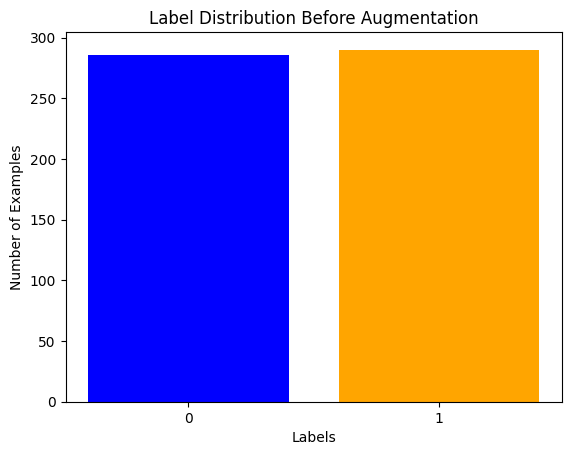

In [19]:
from collections import Counter
import matplotlib.pyplot as plt

# Count the number of examples for each label
label_counts = Counter(dataset["train"]["label"])

# Print the counts for each label
print("Label Distribution Before Augmentation:")
for label, count in label_counts.items():
    print(f"Label {label}: {count} examples")

# Visualize the label distribution
labels = list(label_counts.keys())
counts = list(label_counts.values())

plt.bar(labels, counts, color=['blue', 'orange'])
plt.xlabel("Labels")
plt.ylabel("Number of Examples")
plt.title("Label Distribution Before Augmentation")
plt.xticks(labels)
plt.show()


### How Does Data Augmentation Help in Predicting Biased Sentences?

Data augmentation is a powerful technique for improving bias detection in machine learning models. While augmentation does not directly "predict" biases, it helps the model learn to recognize and generalize beyond stereotypical patterns.

#### Why Use Augmentation for Bias Detection?
1. **Focus on Context, Not Stereotypes**:
   - Augmented examples challenge the model to pay attention to the meaning of the sentence, rather than sensitive attributes like gender or occupation.
   - For example:
     - Original: *"The doctor said he would see the patient."*  
     - Augmented: *"The nurse said she would see the patient."*

2. **Expose and Reduce Dataset Bias**:
   - If the original dataset contains implicit biases (e.g., "doctor" is often paired with "he"), the model might perpetuate these patterns.
   - Augmentation adds diversity to the dataset, exposing these biases and reducing their influence.

3. **Balance Sensitive Attributes**:
   - In real-world data, terms like "doctor" or "nurse" might not appear equally with "he" or "she."
   - Augmentation ensures the model sees all combinations, improving fairness and robustness.

#### Practical Example
Imagine the dataset contains only sentences like this:
- *"The doctor said he would see the patient." (label: 1)*

Without augmentation, the model might incorrectly associate "doctor" with "he" as unbiased.

With augmentation, we add a counterfactual:
- *"The nurse said she would see the patient." (label: 1)*

Now, the model learns that "doctor" and "nurse" shouldn't affect the bias label.

#### Key Benefits of Augmentation
1. **Improved Generalization**:
   - The model becomes better at handling unseen data by learning diverse patterns.
2. **Uncovering Hidden Biases**:
   - Augmentation reveals biases that might not be obvious in the original dataset.
3. **Better Performance in Real-World Scenarios**:
   - The model is exposed to a variety of sentence structures, reducing overfitting.



In [20]:
# Augment the training data
bias_replacements = {"he": "she", "his": "her", "doctor": "nurse"}

def augment_sentence(sentence, replacements):
    """
    Replaces specified words in a sentence to create counterfactual examples.
    Args:
        sentence: The original sentence.
        replacements: A dictionary of words to replace and their replacements.
    Returns:
        Augmented sentence with specified replacements.
    """
    for word, replacement in replacements.items():
        sentence = sentence.replace(word, replacement)
    return sentence

def augment_dataset(dataset, replacements):
    """
    Augments a dataset by adding counterfactual examples.
    Args:
        dataset: The original dataset (Hugging Face Dataset object).
        replacements: A dictionary of words to replace and their replacements.
    Returns:
        Augmented dataset containing original and counterfactual examples.
    """
    augmented_data = []
    for example in dataset:
        # Add original sentence
        augmented_data.append(example)

        # Add augmented sentence
        augmented_sentence = augment_sentence(example["sentence"], replacements)
        augmented_example = {
            "sentence": augmented_sentence,
            "label": example["label"]
        }
        augmented_data.append(augmented_example)

    return augmented_data

# Apply augmentation to the train split
train_data = dataset["train"]
augmented_train_data = augment_dataset(train_data, bias_replacements)

# Convert to Hugging Face Dataset
augmented_train_dataset = Dataset.from_dict({
    "sentence": [example["sentence"] for example in augmented_train_data],
    "label": [example["label"] for example in augmented_train_data]
})

# Replace the original train split with the augmented dataset
dataset["train"] = augmented_train_dataset
print("Number of examples in augmented train dataset:", len(dataset["train"]))


Number of examples in augmented train dataset: 1152


In [21]:
label_counts = Counter(dataset["train"]["label"])
print("Label distribution:", label_counts)


Label distribution: Counter({1: 580, 0: 572})


In [22]:
# Define the models to compare

model_names = {
    "DistilBERT": "distilbert-base-uncased",
    "MiniLM": "microsoft/MiniLM-L12-H384-uncased",
    "TinyBERT": "huawei-noah/TinyBERT_General_4L_312D"
}

### **Why Do We Need Preprocessing?**
Before we can train a model, we need to convert raw text into a format that the model understands. This involves **tokenization**, where sentences are broken into smaller components (like words or subwords) and mapped to numeric IDs.

### **What Will We Do in This Step?**
1. Load a tokenizer from the Hugging Face library.
2. Preprocess the sentences in the dataset.

Now, let’s tokenize the dataset!

In [23]:
# Preprocess the Data**
# To train the model, we need to tokenize the text so it can be processed by models.

# Function to tokenize the dataset
def tokenize_dataset(dataset, model_path):
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    def preprocess_function(examples):
        return tokenizer(examples["sentence"], truncation=True, padding="max_length", max_length=128)

    tokenized_dataset = dataset.map(preprocess_function, batched=True)
    print("Tokenization complete!")
    return tokenized_dataset, tokenizer


## **Step 4: Fine-Tune the Model**
### **What Is Fine-Tuning?**
Fine-tuning involves taking a pre-trained model (like DistilBERT) and training it on a specific task (bias detection). This allows the model to adapt to your dataset while leveraging the knowledge it has already learned from vast amounts of text.

### **What Will We Do in This Step?**
1. Load the pre-trained DistilBERT model.
2. Define training parameters.
3. Fine-tune the model using the tokenized dataset.

Let’s begin!


In [24]:
pip install --upgrade transformers accelerate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [25]:
def train_and_evaluate_model(model_name, model_path, tokenized_dataset):
    """
    Train and evaluate a single model.
    """
    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2).to(device)

    # Define metrics
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = logits.argmax(axis=-1)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
        acc = accuracy_score(labels, predictions)
        return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f"./results_{model_name}",
        evaluation_strategy="epoch",
        learning_rate=5e-5,
        num_train_epochs=3,
        per_device_train_batch_size=8,
        gradient_accumulation_steps=2,  # Accumulate gradients to simulate a larger batch
        save_steps=1000,
        logging_dir=f"./logs_{model_name}",
        logging_steps=100,
        weight_decay=0.01
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        compute_metrics=compute_metrics
    )

    # Train the model
    print(f"Starting Training for {model_name}...")
    trainer.train()

    # Evaluate the model
    print(f"Evaluating the model {model_name}...")
    metrics = trainer.evaluate()
    print(f"Evaluation Metrics for {model_name}:", metrics)

    return model



## **Step 5: Save the Model**

After training the model, it’s important to save it along with the tokenizer. This ensures that the trained model can be reused for testing, inference, or deployment without needing to retrain it.

---

### **Why Save the Model?**

- **Reuse**: The saved model can be loaded anytime for predictions or further fine-tuning.  
- **Portability**: You can transfer the model to another environment or share it with others.  
- **Deployment**: Saved models are essential for deploying AI solutions in production systems.

---

### **How to Save the Model?**

We will:
1. Save the fine-tuned model weights.  
2. Save the tokenizer configuration.



In [26]:
def save_model_and_tokenizer(model, tokenizer, model_name):
    """
    Saves the model and tokenizer to a specified directory.
    Args:
        model: The trained model to save.
        tokenizer: The tokenizer to save.
        model_name: The name of the model (used for directory naming).
    """
    save_path = f"./{model_name}_bias-mitigation-model"
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
    print(f"Model and tokenizer for {model_name} saved successfully at {save_path}!")


## **Step 6: Test the Model**

Now that the model is fine-tuned, let’s test it with an example sentence to see how well it performs. This step will load the trained model and tokenizer for inference and run it on a sample input.

---

### **Why Are We Testing the Model?**

After training, it’s important to check if the model can make meaningful predictions. By testing it on a specific sentence, we can verify if the model understands and detects potential bias.

---

### **What Will We Do?**

1. Load the fine-tuned model and tokenizer.
2. Prepare a sample input sentence.
3. Run inference and analyze the output.


In [27]:
def test_model(model_name, model_path, tokenizer_path, test_sentences):
    """
    Test a trained model on example sentences.
    """
    # Load the trained model and tokenizer
    classifier = pipeline("text-classification", model=model_path, tokenizer=tokenizer_path)

    print(f"Testing the model {model_name}...")
    for sentence in test_sentences:
        result = classifier(sentence)
        print(f"Input: {sentence}")
        print(f"Prediction: {result}")
        print("-" * 50)


# Execute for Each Model

In [28]:
# Test sentences
test_sentences = [
    "The nurse said the doctor would see the patient soon.",
    "The CEO welcomed the new male engineer.",
    "She is a great leader and makes tough decisions.",
    "The teacher said that he would grade the exams by tomorrow.",
    "The firefighter saved the child from the burning building.",
    "She is a nurse, and he is a doctor.",
    "The programmer quickly fixed the critical bug."
]

# Loop through models
for model_name, model_path in model_names.items():
    print(f"Processing model: {model_name}")
    
    # Tokenize the dataset
    tokenized_dataset, tokenizer = tokenize_dataset(dataset, model_path)
    
    # Train and evaluate
    model = train_and_evaluate_model(model_name, model_path, tokenized_dataset)

    # Save the model and tokenizer
    model.save_pretrained(f"./{model_name}_bias-mitigation-model")
    tokenizer.save_pretrained(f"./{model_name}_bias-mitigation-model")
    print(f"Model and tokenizer for {model_name} saved successfully!")

    # Test the model
    test_model(model_name, f"./{model_name}_bias-mitigation-model", f"./{model_name}_bias-mitigation-model", test_sentences)

    print(f"Completed processing for {model_name}.\n")


Processing model: DistilBERT


Map:   0%|          | 0/1152 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenization complete!


/Users/Senjuti/Library/Python/3.9/lib/python/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting Training for DistilBERT...


Epoch,Training Loss,Validation Loss




## **Output Explanation**

When you test the fine-tuned model, it will generate an output for each input sentence. The output provides two key pieces of information:

### **1. `label`**
- This field indicates whether bias was detected in the input sentence.
- Common values:
  - **`LABEL_0`**: No bias detected.
  - **`LABEL_1`**: Bias detected.
- These labels correspond to the two classes the model was trained to predict. You can customize these labels during fine-tuning (e.g., replacing `LABEL_0` with "No Bias" and `LABEL_1` with "Bias Detected").

---

### **2. `score`**
- This field represents the model's confidence in its prediction.
- The value is a probability ranging between **0** and **1**, where:
  - **Close to 1**: The model is very confident in its prediction.
  - **Close to 0**: The model is uncertain about its prediction.
- Example:
  - If the `score` is `0.85` for `LABEL_1`, the model is 85% confident that bias is present in the sentence.

---

### **Sample Output**
```json
[
    {
        "label": "LABEL_1",
        "score": 0.85
    }
]
```

#### **Interpretation**:
- **`label`**: `"LABEL_1"` means the model detected bias in the input sentence.
- **`score`**: `0.85` means the model is 85% confident about this prediction.



